# HDR Plot - an example with 3 components

In this example, we present the HDR analysis on the *El Niño* dataset based on a dimension reduction with 3 components. We hows that projections issues are raised when the outliers are projected onto 2 dimensions.

The *El Niño* dataset consists of 60 years worth of averaged monthly sea surface temperature (SST) in degrees Celcius of the Pacific Ocean at 0-10 deg South and 90-80 deg West between 1950 and 2007.
Years 1982-83 and 1997-98 are outliers; these are the years where *El Niño* (a climate pattern characterized by warming up of the sea surface and higher air pressures) occurred with unusual intensity.

Source: NOAA - ERSSTv5 - Nino 1+2 at http://www.cpc.ncep.noaa.gov/data/indices/

In [1]:
import os
import openturns as ot
from othdrplot import ProcessHighDensityRegionAlgorithm
import othdrplot as othdr
import openturns.viewer as otv
import numpy as np

The minimum volume level set computation requires a sampling which can be costly with the default value of the parameters, due to a huge sampling size. Hence, we reduce it to 10000.

In [2]:
n_samples = 10000
ot.ResourceMap.SetAsBool("Distribution-MinimumVolumeLevelSetBySampling", True)
ot.ResourceMap.SetAsUnsignedInteger(
    "Distribution-MinimumVolumeLevelSetSamplingSize", n_samples
)

Load the dataset.

In [3]:
basename = "sstoi.indices.txt"
filename = os.path.join(othdr.__path__[0], "data", basename)
separatorstr = " "
raw_data = ot.Sample.ImportFromTextFile(filename, separatorstr)
raw_data.setDescription(
    [
        "YR",
        "MON",
        "NINO1+2",
        "ANOM",
        "NINO3",
        "ANOM",
        "NINO4",
        "ANOM",
        "NINO3.4",
        "ANOM",
    ]
)
number_of_rows = raw_data.getSize()
number_of_years = int(number_of_rows / 12.0)
total_column = np.array(raw_data[:, 2]).reshape((number_of_years, 12))
data = ot.Sample(total_column)
data.setDescription(
    ["Jan", "Fev", "Mar", "Apr", "May", "Jun", "Jui", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
data[:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=12 description=[Jan,Fev,Mar,Apr,May,Jun,Jui,Aug,Sep,Oct,Nov,Dec] data=[[24.29,25.49,25.21,24.5,23.97,22.89,22.47,21.75,21.8,22.94,24.59,26.13],[27.42,28.09,28.68,28.56,28.19,27.44,25.95,23.78,22.24,21.86,21.9,23.01],[24.18,25.18,26,25.16,23.23,21.96,21.24,20.17,20.37,20.52,21.5,22.58],[23.59,24.87,25.74,24.25,22.29,21.75,20.44,19.29,19.44,19.9,20.69,22.4],[24.61,26.06,25.91,24.58,23.38,21.98,21.12,20.97,20.44,21.07,22.03,23]]

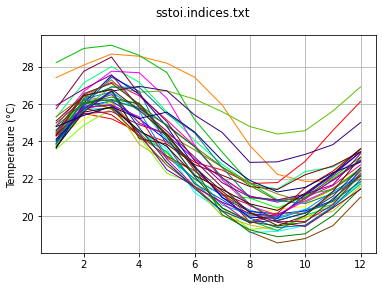

In [14]:
graph = ot.Graph(basename, "Month", "Temperature (°C)", True)
for i in range(number_of_years):
    curve = ot.Curve(range(1, 13), data[i])
    graph.add(curve)
graph.setColors(ot.DrawableImplementation_BuildRainbowPalette(number_of_years))
view = otv.View(graph)

Create the mesh.

In [5]:
print("Number of dates : %d" % (data.getDimension()))
print("Number of fields : %d" % (data.getSize()))

Number of dates : 12
Number of fields : 39


In [6]:
n_nodes = data.getDimension()
mesher = ot.IntervalMesher([n_nodes - 1])
interval = ot.Interval([0.0], [1.0])
mesh = mesher.build(interval)

Create the `ProcessSample` from the data.

In [7]:
n_fields = data.getSize()
d_fields = 1
processSample = ot.ProcessSample(mesh, n_fields, d_fields)
for i in range(n_fields):
    trajectory = ot.Sample([[x] for x in data[i, :]])
    processSample[i] = ot.Field(mesh, trajectory)

Use the Karhunen-Loeve to reduce the dimension to 3 components.

In [8]:
# KL decomposition
reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(processSample, 3)
reduction.run()
reducedComponents = reduction.getReducedComponents()

# Distribution fit in reduced space
ks = ot.KernelSmoothing()
reducedDistribution = ks.build(reducedComponents)

The `HighDensityRegionAlgorithm` class plots the high density regions.

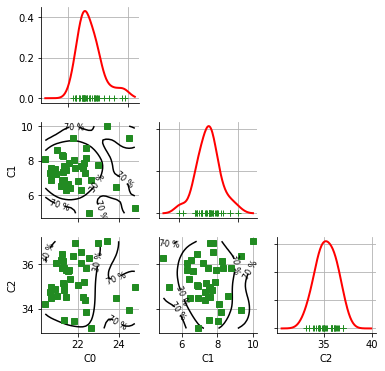

In [9]:
mydp = othdr.HighDensityRegionAlgorithm(
    reducedComponents, reducedDistribution, [0.7, 0.3]
)
mydp.run()
grid = mydp.draw(drawInliers=True)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

The minmum volume level sets are based on the levels $\alpha=0.3$ and $\alpha=0.7$. The sets are computed based on the 3 dimensional distribution. Then these sets are projected on 2 dimension planes. 

We see that red points might be outside but also inside the minimum volume levels set of level $\alpha=0.9$. This is because the minimum volume level set is computed in 3 dimensions, so that outliers are outside the 3D volume with level $\alpha=0.7$. But when these points are projected on two dimensions, it occurs that some points are projected inside the projection of the level set.

Compute HDRPlot: in this example, we set the result of the KL decomposition.

In [10]:
hdr = ProcessHighDensityRegionAlgorithm(
    processSample, reducedComponents, reducedDistribution, [0.7, 0.5]
)
hdr.run()

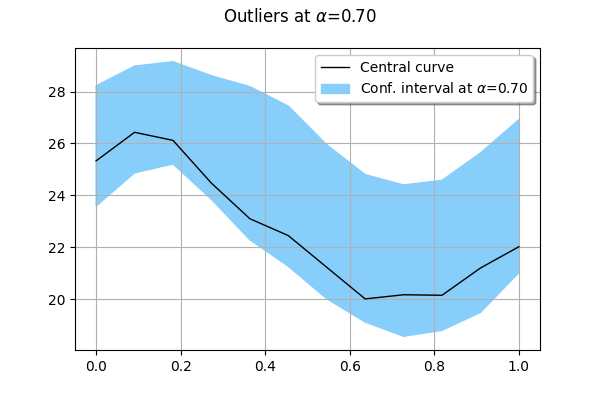

In [11]:
hdr.draw()

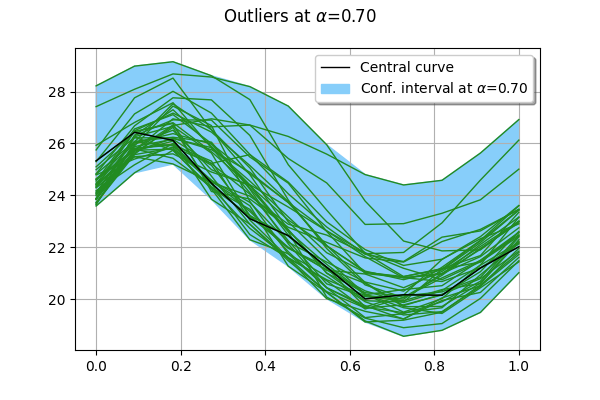

In [12]:
hdr.draw(drawInliers=True)

In [13]:
print("Outliers trajectories")
outlierIndices = hdr.computeIndices()
outlierIndices

Outliers trajectories


[]